from sklearn.preprocessing import RobustScaler
# ^^^ pyforest auto-imports - don't write above this line
___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 11<br><br>Multivariate Time Series Forecasting with RNN<br><br>(Manually)<br><h1>

# Dataset Info

Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), Â°C
- rv1, Random variable 1, nondimensional
- rv2, Random variable 2, nondimensional

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Recognizing and Understanding Data

In [2]:
df = pd.read_csv('../data&resources/energydata_complete.csv',index_col='date', parse_dates = True)

In [3]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890,47.597,19.200,44.790,19.790,44.730,19.000,45.567,17.167,55.200,7.027,84.257,17.200,41.627,18.200,48.900,17.033,45.530,6.600,733.500,92.000,7.000,63.000,5.300,13.275,13.275
2016-01-11 17:10:00,60,30,19.890,46.693,19.200,44.722,19.790,44.790,19.000,45.992,17.167,55.200,6.833,84.063,17.200,41.560,18.200,48.863,17.067,45.560,6.483,733.600,92.000,6.667,59.167,5.200,18.606,18.606
2016-01-11 17:20:00,50,30,19.890,46.300,19.200,44.627,19.790,44.933,18.927,45.890,17.167,55.090,6.560,83.157,17.200,41.433,18.200,48.730,17.000,45.500,6.367,733.700,92.000,6.333,55.333,5.100,28.643,28.643
2016-01-11 17:30:00,50,40,19.890,46.067,19.200,44.590,19.790,45.000,18.890,45.723,17.167,55.090,6.433,83.423,17.133,41.290,18.100,48.590,17.000,45.400,6.250,733.800,92.000,6.000,51.500,5.000,45.410,45.410
2016-01-11 17:40:00,60,40,19.890,46.333,19.200,44.530,19.790,45.000,18.890,45.530,17.200,55.090,6.367,84.893,17.200,41.230,18.100,48.590,17.000,45.400,6.133,733.900,92.000,5.667,47.667,4.900,10.084,10.084


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.000,97.695,102.525,10.000,50.000,60.000,100.000,1080.000
lights,19735.000,3.802,7.936,0.000,0.000,0.000,0.000,70.000
T1,19735.000,21.687,1.606,16.790,20.760,21.600,22.600,26.260
RH_1,19735.000,40.260,3.979,27.023,37.333,39.657,43.067,63.360
T2,19735.000,20.341,2.193,16.100,18.790,20.000,21.500,29.857
RH_2,19735.000,40.420,4.070,20.463,37.900,40.500,43.260,56.027
T3,19735.000,22.268,2.006,17.200,20.790,22.100,23.290,29.236
RH_3,19735.000,39.243,3.255,28.767,36.900,38.530,41.760,50.163
T4,19735.000,20.855,2.043,15.100,19.530,20.667,22.100,26.200
RH_4,19735.000,39.027,4.341,27.660,35.530,38.400,42.157,51.090


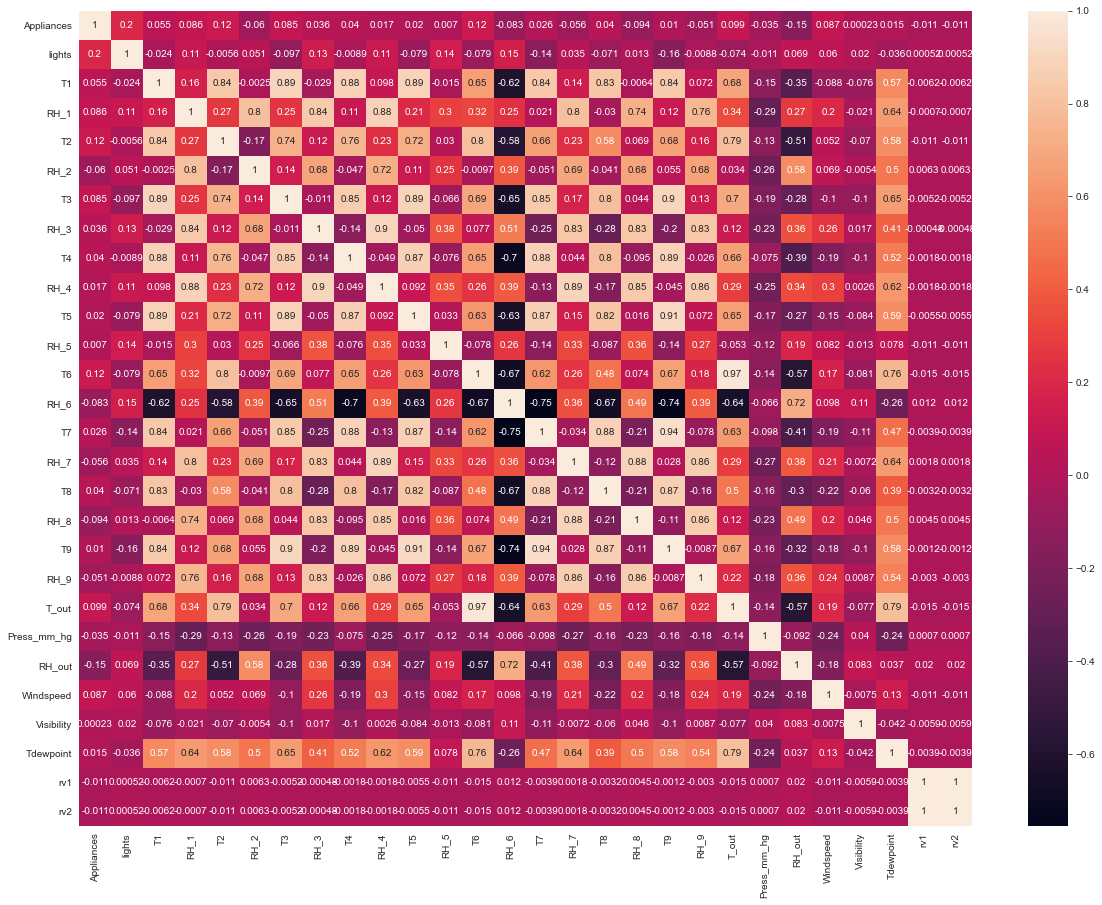

In [6]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

# Data Pre-Processing

## Feature Engineering
- Let's reduce the number of feature
- Let's resample the dataset by hours

In [7]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [8]:
df=df.rename(columns = {'T6':'T_outside', 'RH_6':'RH_outside'})
df["T_inside"] = (df["T1"] + df["T2"] + df["T3"] + df["T4"] + df["T5"] + df["T7"] + df["T8"] + df["T9"])/8
df["RH_inside"] = (df["RH_1"] + df["RH_2"] + df["RH_3"] + df["RH_4"] + df["RH_5"] + df["RH_7"] + df["RH_8"] + df["RH_9"])/8

In [9]:
drop_list = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
             'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'RH_out', 'rv1', 'rv2']
df.drop(drop_list, axis = 1, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T_outside    19735 non-null  float64
 3   RH_outside   19735 non-null  float64
 4   Press_mm_hg  19735 non-null  float64
 5   Windspeed    19735 non-null  float64
 6   Visibility   19735 non-null  float64
 7   Tdewpoint    19735 non-null  float64
 8   T_inside     19735 non-null  float64
 9   RH_inside    19735 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.7 MB


In [11]:
df_a = df[["Appliances", "lights"]]
df_b = df.drop(["Appliances", "lights"], axis = 1)

In [12]:
df_a = df_a.resample("H").sum()
df_b = df_b.resample("H").mean()

In [13]:
df = pd.concat([df_a, df_b], axis =1)
df.head()

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-01-11 17:00:00,330,210,6.587,84.260,733.750,6.167,53.417,5.050,18.415,46.555
2016-01-11 18:00:00,1060,310,6.180,87.204,734.267,5.417,40.000,4.658,18.408,46.520
2016-01-11 19:00:00,1040,150,5.857,88.131,734.792,6.000,40.000,4.392,18.686,48.665
2016-01-11 20:00:00,750,210,5.469,86.934,735.283,6.000,40.000,4.017,18.941,50.356
2016-01-11 21:00:00,620,140,5.579,86.129,735.567,6.000,40.000,3.817,19.254,48.977


In [14]:
df.shape

(3290, 10)

Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network (we will also normalize the data anyways, so this level of precision isn't useful to us)

In [15]:
df = df.round(2)

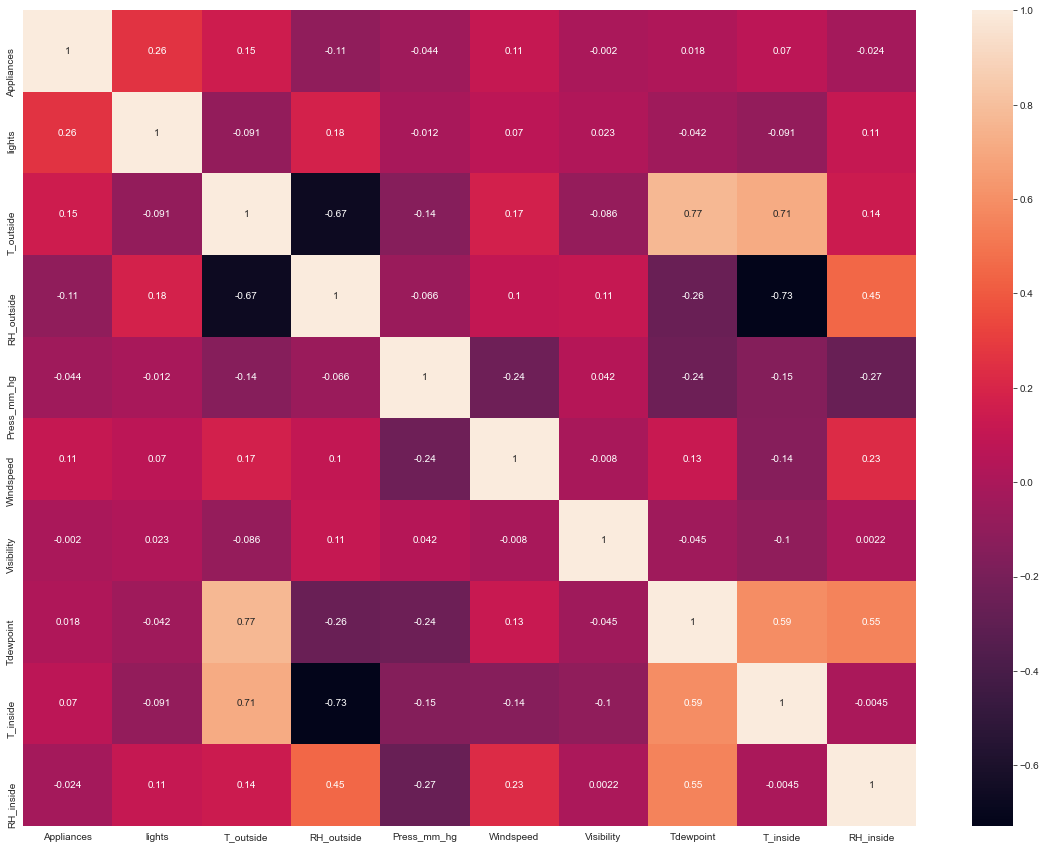

In [16]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

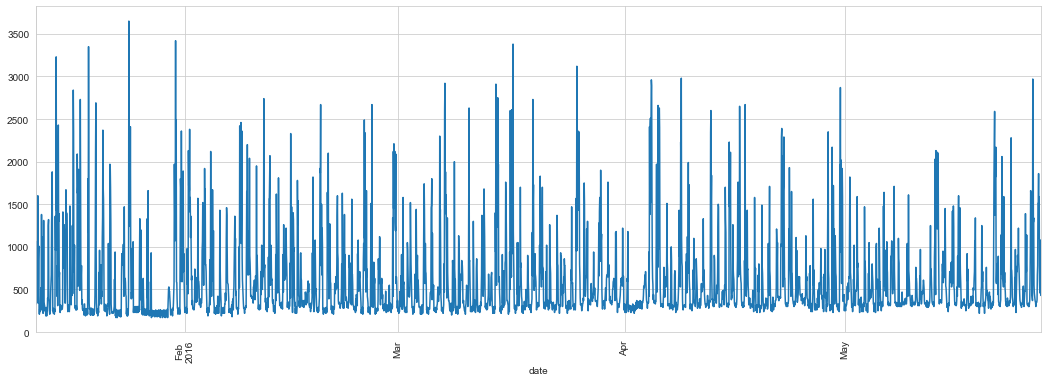

In [17]:
df['Appliances'].plot(figsize=(18,6))
plt.xticks(rotation=90);

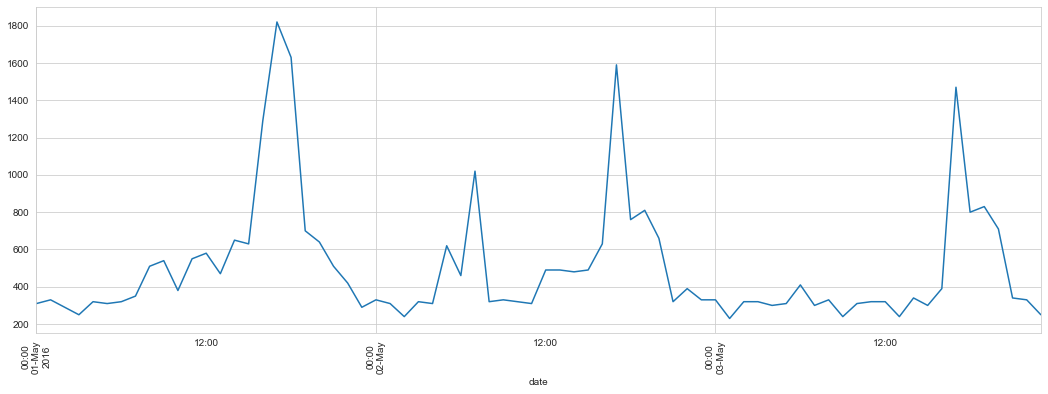

In [18]:
df['Appliances'].loc["2016-05-01 00:00:00" : "2016-05-03 23:00:00"].plot(figsize=(18,6))
plt.xticks(rotation=90);

### Train Test Split

In [19]:
len(df)

3290

In [20]:
# How many rows per day?
24

24

In [21]:
test_days = 7

In [22]:
test_ind = test_days*24

In [23]:
test_ind

168

In [24]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [25]:
train.shape, test.shape

((3122, 10), (168, 10))

### Scale Data

In [26]:
df.columns

Index(['Appliances', 'lights', 'T_outside', 'RH_outside', 'Press_mm_hg',
       'Windspeed', 'Visibility', 'Tdewpoint', 'T_inside', 'RH_inside'],
      dtype='object')

In [27]:
f_columns = df.columns[1:]

f_transformer = RobustScaler()
target_transformer = RobustScaler()

train.loc[:, f_columns] = f_transformer.fit_transform(train[f_columns])
train['Appliances'] = target_transformer.fit_transform(train[['Appliances']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns])
test['Appliances'] = target_transformer.transform(test[['Appliances']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Define a Function for Creating Time Steps 

In [28]:
def create_dataset(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: Count "cnt" value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [29]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Appliances, time_steps)
X_test, y_test = create_dataset(test, test.Appliances, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3098, 24, 10) (3098,)
(144, 24, 10) (144,)


## Model Building with LSTM

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
n_features = X_train.shape[2]

In [32]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, input_shape=(time_steps, n_features))))

#model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [33]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [34]:
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=1, 
          validation_split=0.3,
#          shuffle=False,
          callbacks=[early_stop])

Epoch 1/30
2168/2168 [==============================] - 22s 9ms/step - loss: 1.3358 - val_loss: 0.8179
Epoch 2/30
2168/2168 [==============================] - 18s 8ms/step - loss: 1.2130 - val_loss: 0.8404
Epoch 3/30
2168/2168 [==============================] - 17s 8ms/step - loss: 1.1685 - val_loss: 0.8102
Epoch 4/30
2168/2168 [==============================] - 17s 8ms/step - loss: 1.1102 - val_loss: 0.8082
Epoch 5/30
2168/2168 [==============================] - 17s 8ms/step - loss: 1.0654 - val_loss: 0.8585
Epoch 6/30
2168/2168 [==============================] - 18s 8ms/step - loss: 0.9764 - val_loss: 0.8143
Epoch 7/30
2168/2168 [==============================] - 18s 8ms/step - loss: 0.9270 - val_loss: 1.0493
Epoch 8/30
2168/2168 [==============================] - 17s 8ms/step - loss: 0.8814 - val_loss: 1.0482
Epoch 9/30
2168/2168 [==============================] - 18s 8ms/step - loss: 0.7731 - val_loss: 0.8700


<AxesSubplot:>

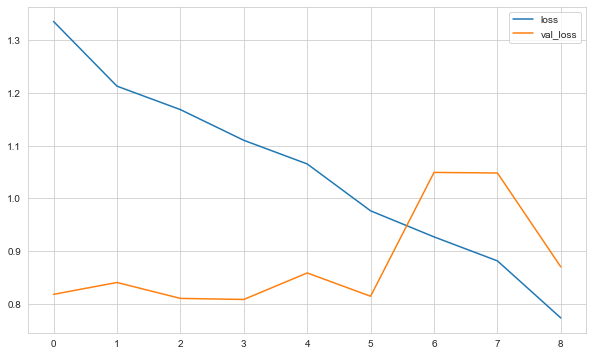

In [35]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [37]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

### First way : after each prediction, reel value will be use for next prediction¶

In [38]:
y_pred = model.predict(X_test)

In [39]:
eval_metrics(y_test, y_pred)

r2_score: 0.11444114384152371 
mae: 0.8254358189433445 
mse: 1.5451978300235019 
rmse: 1.243059865824451


#### Inverse Transform

In [40]:
y_train_inv = target_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = target_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = target_transformer.inverse_transform(y_pred)

In [41]:
test_index = test.iloc[time_steps:].index

pred_test = pd.concat([pd.DataFrame(y_test_inv.reshape(-1, 1)),
                       pd.DataFrame(y_pred_inv)], axis = 1)
pred_test.columns=['test','prediction']
pred_test.index = test_index
pred_test

,test,prediction
date,,
2016-05-21 19:00:00,650.000,989.369
2016-05-21 20:00:00,570.000,761.354
2016-05-21 21:00:00,810.000,526.111
2016-05-21 22:00:00,440.000,561.366
2016-05-21 23:00:00,890.000,445.206
...,...,...
2016-05-27 14:00:00,610.000,830.611
2016-05-27 15:00:00,460.000,757.435
2016-05-27 16:00:00,810.000,629.778


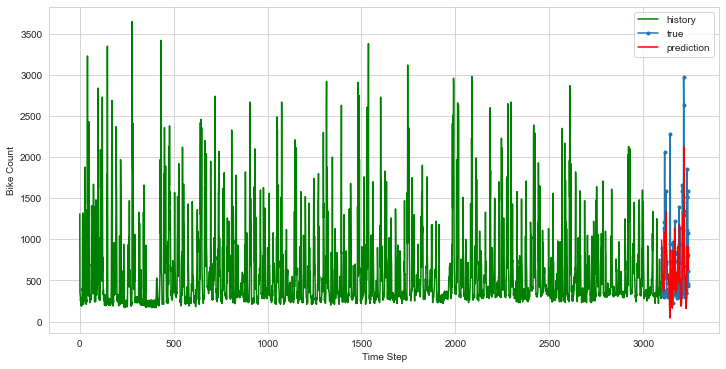

In [42]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

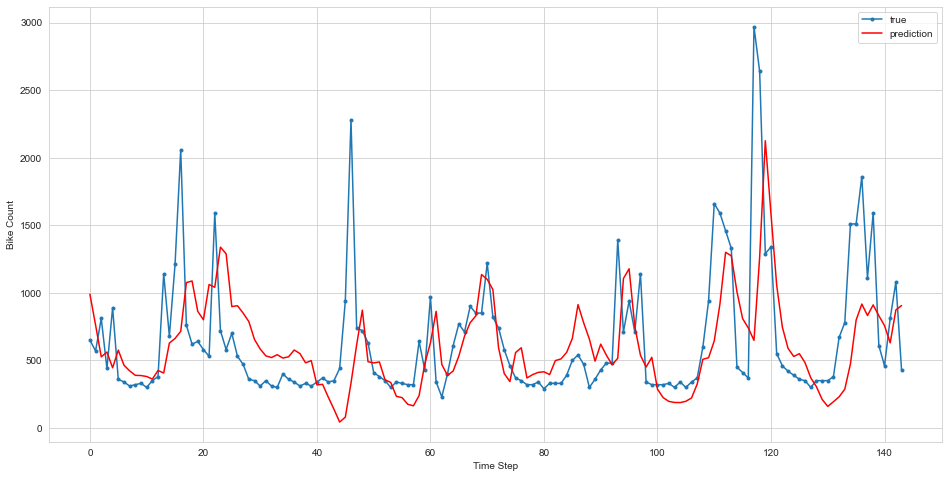

In [43]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Second way : after each prediction, result will be use for next prediction

In [44]:
train

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-01-11 17:00:00,-0.111,10.500,-0.041,0.525,-2.117,0.723,1.643,0.366,-1.061,1.099
2016-01-11 18:00:00,1.917,15.500,-0.098,0.582,-2.067,0.514,0.000,0.291,-1.066,1.093
2016-01-11 19:00:00,1.861,7.500,-0.143,0.600,-2.018,0.676,0.000,0.239,-0.923,1.478
2016-01-11 20:00:00,1.056,10.500,-0.198,0.577,-1.971,0.676,0.000,0.168,-0.796,1.781
2016-01-11 21:00:00,0.694,7.000,-0.182,0.562,-1.943,0.676,0.000,0.129,-0.638,1.534
...,...,...,...,...,...,...,...,...,...,...
2016-05-20 14:00:00,-0.028,0.000,1.653,-0.580,0.226,0.235,0.000,1.999,1.291,0.934
2016-05-20 15:00:00,-0.250,0.000,1.929,-0.790,0.220,0.279,0.000,1.876,1.342,0.941
2016-05-20 16:00:00,-0.222,0.000,1.988,-1.045,0.209,0.235,0.000,1.777,1.378,0.848


In [45]:
df_fake = test.iloc[:time_steps,1:]
df_fake

,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-05-20 19:00:00,0.000,1.852,-1.082,0.196,0.279,0.000,1.178,1.500,0.975
2016-05-20 20:00:00,0.000,1.296,-0.898,0.201,-0.115,0.000,1.151,1.423,0.790
2016-05-20 21:00:00,0.500,0.999,-0.598,0.209,-0.559,0.000,1.384,1.367,0.767
2016-05-20 22:00:00,0.500,0.873,-0.435,0.220,-0.721,0.000,1.482,1.347,0.828
2016-05-20 23:00:00,0.000,0.890,-0.289,0.209,-0.603,-0.561,1.631,1.321,0.889
2016-05-21 00:00:00,0.000,0.864,-0.193,0.180,-0.324,-1.398,1.829,1.301,0.941
2016-05-21 01:00:00,0.000,0.892,-0.131,0.143,-0.045,-0.857,1.833,1.286,0.964
2016-05-21 02:00:00,0.000,0.852,-0.123,0.104,0.117,0.000,1.822,1.276,0.977
2016-05-21 03:00:00,0.000,0.773,-0.107,0.076,0.117,-0.561,1.799,1.265,0.987


In [46]:
reel = np.array(test.iloc[:time_steps,:1])
reel.reshape((1,-1))[0]

array([ 0.05555556,  0.13888889,  0.05555556, -0.13888889, -0.27777778,
       -0.22222222, -0.16666667, -0.08333333, -0.22222222, -0.08333333,
       -0.16666667, -0.02777778, -0.08333333,  2.44444444,  4.13888889,
        5.36111111,  6.16666667,  2.77777778,  4.69444444,  4.02777778,
        5.        ,  0.63888889,  0.55555556,  1.05555556])

In [47]:
df_fake.shape

(24, 9)

In [48]:
df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1])).shape

(24, 1, 9)

In [49]:
predictions_scaled = []

first_eval_batch = train.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, n_features))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(time_steps):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0])
    new = features[i][0].tolist()
    new.insert(0,current_pred[0][0])
    new = np.array(new).reshape(1,1,n_features)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis=1)

In [50]:
predictions_scaled

[array([-0.17104314], dtype=float32),
 array([-0.69869816], dtype=float32),
 array([-0.9076797], dtype=float32),
 array([-0.6467724], dtype=float32),
 array([-0.455428], dtype=float32),
 array([-0.4462453], dtype=float32),
 array([-0.3794086], dtype=float32),
 array([-0.43927687], dtype=float32),
 array([-0.5518133], dtype=float32),
 array([-0.5350476], dtype=float32),
 array([-0.3007807], dtype=float32),
 array([-0.09619914], dtype=float32),
 array([0.14408948], dtype=float32),
 array([0.339898], dtype=float32),
 array([0.53282017], dtype=float32),
 array([0.6172194], dtype=float32),
 array([1.0336326], dtype=float32),
 array([1.9147903], dtype=float32),
 array([2.4006455], dtype=float32),
 array([2.3168569], dtype=float32),
 array([1.9203819], dtype=float32),
 array([1.7036511], dtype=float32),
 array([1.5343243], dtype=float32),
 array([1.1846238], dtype=float32)]

In [51]:
reel

array([[ 0.05555556],
       [ 0.13888889],
       [ 0.05555556],
       [-0.13888889],
       [-0.27777778],
       [-0.22222222],
       [-0.16666667],
       [-0.08333333],
       [-0.22222222],
       [-0.08333333],
       [-0.16666667],
       [-0.02777778],
       [-0.08333333],
       [ 2.44444444],
       [ 4.13888889],
       [ 5.36111111],
       [ 6.16666667],
       [ 2.77777778],
       [ 4.69444444],
       [ 4.02777778],
       [ 5.        ],
       [ 0.63888889],
       [ 0.55555556],
       [ 1.05555556]])

In [52]:
eval_metrics(reel, predictions_scaled)

r2_score: 0.18778956105415368 
mae: 1.2676830175160259 
mse: 3.724614658159019 
rmse: 1.9299260758275223


## Inverse Transformations and Compare

In [53]:
predictions = target_transformer.inverse_transform(predictions_scaled)
reel = target_transformer.inverse_transform(reel)

In [54]:
compare = pd.DataFrame(data = reel, index = test.index[:time_steps], columns = ["reel"])
compare["prediction"] = predictions
compare

,reel,prediction
date,,
2016-05-20 19:00:00,390.000,308.424
2016-05-20 20:00:00,420.000,118.469
2016-05-20 21:00:00,390.000,43.235
2016-05-20 22:00:00,320.000,137.162
2016-05-20 23:00:00,270.000,206.046
2016-05-21 00:00:00,290.000,209.352
2016-05-21 01:00:00,310.000,233.413
2016-05-21 02:00:00,340.000,211.860
2016-05-21 03:00:00,290.000,171.347


<AxesSubplot:xlabel='date'>

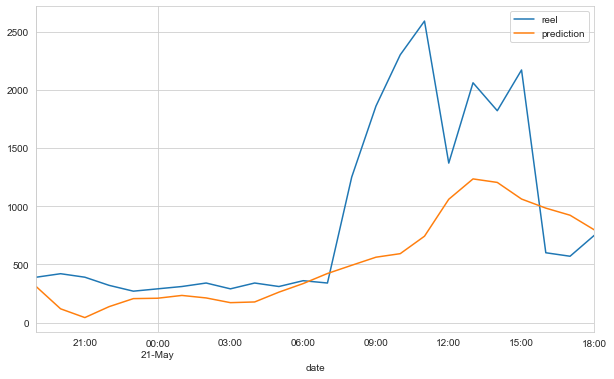

In [55]:
compare.plot()

## Retrain and Forecasting with Full Data

### Scale full data

In [56]:
df_scaled = df.copy()

In [57]:
f_columns = df_scaled.columns[1:]

f_transformer = RobustScaler()
target_transformer = RobustScaler()

df_scaled.loc[:, f_columns] = f_transformer.fit_transform(df_scaled[f_columns])
df_scaled['Appliances'] = target_transformer.fit_transform(df_scaled[['Appliances']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
df_scaled

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-01-11 17:00:00,-0.139,10.500,-0.092,0.546,-2.233,0.757,1.643,0.290,-1.038,1.027
2016-01-11 18:00:00,1.889,15.500,-0.146,0.601,-2.181,0.538,0.000,0.221,-1.043,1.022
2016-01-11 19:00:00,1.833,7.500,-0.188,0.619,-2.129,0.708,0.000,0.173,-0.910,1.392
2016-01-11 20:00:00,1.028,10.500,-0.239,0.596,-2.080,0.708,0.000,0.107,-0.790,1.682
2016-01-11 21:00:00,0.667,7.000,-0.225,0.581,-2.051,0.708,0.000,0.072,-0.643,1.445
...,...,...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,0.639,0.500,2.403,-1.016,-0.030,-0.462,-2.255,1.785,2.024,0.914
2016-05-27 15:00:00,0.222,0.000,2.496,-1.016,-0.042,-0.462,-2.224,1.746,2.019,0.833
2016-05-27 16:00:00,1.194,0.000,2.478,-1.016,-0.072,-0.339,-2.132,1.749,2.043,0.931


Let's devide dataset as "full" and "val". We can think about this "val" data as the weather forecast of next days.

In [59]:
val_size = 24
val = df_scaled.iloc[-val_size:]
full = df_scaled.iloc[:-val_size]
print(len(full), len(val))

3266 24


### reshape to [samples, time_steps, n_features]

In [60]:
X, y = create_dataset(full, full.Appliances, time_steps)

print(X.shape, y.shape)

(3242, 24, 10) (3242,)


### Create Final model with full data

In [61]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, input_shape=(time_steps, n_features))))

#model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [62]:
model.fit(X, y, 
          epochs=15, 
          batch_size=1, 
         # shuffle=False
         )

Epoch 1/15
3242/3242 [==============================] - 27s 7ms/step - loss: 1.1944
Epoch 2/15
3242/3242 [==============================] - 24s 7ms/step - loss: 1.0918
Epoch 3/15
3242/3242 [==============================] - 24s 7ms/step - loss: 1.0628
Epoch 4/15
3242/3242 [==============================] - 24s 7ms/step - loss: 1.0178
Epoch 5/15
3242/3242 [==============================] - 24s 7ms/step - loss: 0.9760
Epoch 6/15
3242/3242 [==============================] - 25s 8ms/step - loss: 0.9521
Epoch 7/15
3242/3242 [==============================] - 24s 7ms/step - loss: 0.8981
Epoch 8/15
3242/3242 [==============================] - 24s 8ms/step - loss: 0.8336
Epoch 9/15
3242/3242 [==============================] - 24s 7ms/step - loss: 0.7755
Epoch 10/15
3242/3242 [==============================] - 24s 7ms/step - loss: 0.7051
Epoch 11/15
3242/3242 [==============================] - 24s 7ms/step - loss: 0.6340
Epoch 12/15
3242/3242 [==============================] - 25s 8ms/step - lo

<AxesSubplot:>

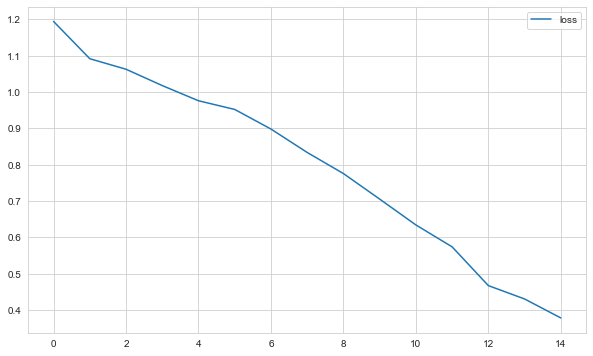

In [63]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### forecasting

In [64]:
df_fake = val.iloc[:,1:]
df_fake

,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-05-26 19:00:00,0.000,2.011,-1.016,-0.060,-0.170,-0.786,1.134,1.862,0.749
2016-05-26 20:00:00,4.500,1.634,-1.006,-0.048,-0.170,-0.867,1.237,1.838,1.143
2016-05-26 21:00:00,4.000,1.311,-0.842,-0.018,-0.047,-0.092,1.368,1.762,0.990
2016-05-26 22:00:00,6.000,1.111,-0.704,0.000,0.123,2.794,1.444,1.738,0.974
2016-05-26 23:00:00,5.500,0.996,-0.619,0.000,0.000,2.886,1.403,1.695,0.954
2016-05-27 00:00:00,1.000,0.932,-0.513,-0.008,-0.292,2.764,1.355,1.671,0.966
2016-05-27 01:00:00,0.000,0.910,-0.465,-0.028,-0.462,2.693,1.338,1.633,0.959
2016-05-27 02:00:00,0.000,0.875,-0.401,-0.036,-0.585,2.641,1.334,1.605,0.974
2016-05-27 03:00:00,0.000,0.833,-0.336,-0.042,-0.389,2.163,1.375,1.576,0.983


In [65]:
reel = np.array(val.iloc[:,:1])
reel.reshape((1,-1))[0]

array([ 2.66666667,  0.47222222,  0.22222222,  0.11111111,  0.02777778,
       -0.05555556, -0.08333333, -0.22222222, -0.08333333, -0.08333333,
       -0.08333333,  0.        ,  0.80555556,  1.11111111,  3.13888889,
        3.13888889,  4.11111111,  2.02777778,  3.36111111,  0.63888889,
        0.22222222,  1.19444444,  1.94444444,  0.13888889])

### First way : after each prediction, reel value will be use for next prediction¶

In [66]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = full.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, full.shape[1]))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0][0]
    
    # store prediction
    forecast.append(current_pred) 
    new = features[i][0].tolist()
    new.insert(0,reel[i][0])
    new = np.array(new).reshape(1,1,full.shape[1])
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis = 1)

In [67]:
eval_metrics(reel.reshape((1,-1))[0], forecast)

r2_score: -0.24120226000932998 
mae: 0.8172168983491481 
mse: 2.151107322563645 
rmse: 1.4666653751158254


In [68]:
forecast = target_transformer.inverse_transform(np.array(forecast).reshape(1,-1))
forecast

array([[ 995.31934,  888.55115,  212.44391,  454.0621 ,  652.1497 ,
         326.21225,  335.29868,  283.33197,  241.9474 ,  259.96777,
         309.48358,  361.7654 ,  401.77106,  581.7407 , 1362.7415 ,
        1555.9401 , 1175.065  , 1110.8944 ,  905.6884 ,  755.43933,
         694.31226,  846.20105, 2137.1377 , 2438.8433 ]], dtype=float32)

In [69]:
forecast_index = pd.date_range(start = '2016-05-26 19:00:00', periods = periods, freq = 'H')

In [70]:
forecast_df = pd.DataFrame(data = forecast.reshape(-1, 1), index = forecast_index, columns = ['Forecast'])

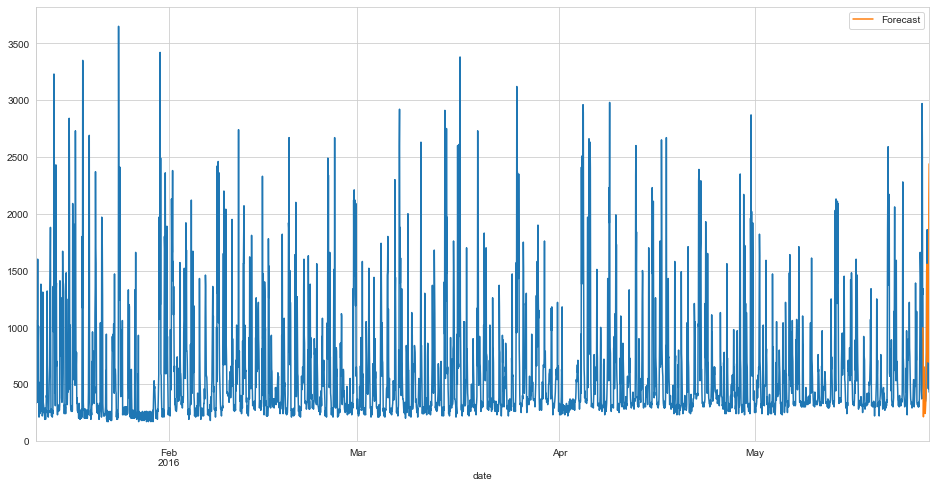

In [71]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(406699.0, 406770.0)

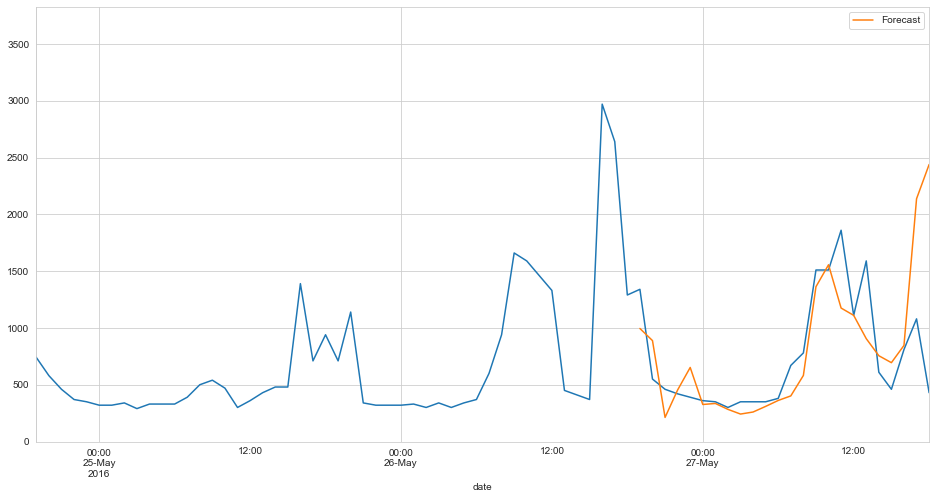

In [72]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2016-05-24 19:00:00', '2016-05-27 18:00:00')

### Second way : after each prediction, result will be use for next prediction

In [73]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = full.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, full.shape[1]))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0][0]
    
    # store prediction
    forecast.append(current_pred) 
    new = features[i][0].tolist()
    new.insert(0,current_pred)
    new = np.array(new).reshape(1,1,full.shape[1])
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis = 1)

In [74]:
eval_metrics(reel.reshape((1,-1))[0], forecast)

r2_score: -2.0151743131622286 
mae: 1.5410410246501367 
mse: 5.225549253995335 
rmse: 2.2859460304205204


In [75]:
forecast = target_transformer.inverse_transform(np.array(forecast).reshape(1,-1))
forecast

array([[ 995.31934,  688.6701 ,  291.0424 ,  595.08105,  459.75882,
         393.98407,  368.59814,  289.3606 ,  241.33586,  236.91281,
         253.19084,  296.04187,  341.77097,  319.22064,  285.33206,
         206.55817,  -76.61273, -376.9156 , -497.25995, -360.9469 ,
        -262.2669 ,  266.57333,  539.7101 ,  776.86914]], dtype=float32)

In [76]:
forecast_index = pd.date_range(start = '2016-05-26 19:00:00', periods = periods, freq = 'H')

In [77]:
forecast_df = pd.DataFrame(data = forecast.reshape(-1, 1), index = forecast_index, columns = ['Forecast'])

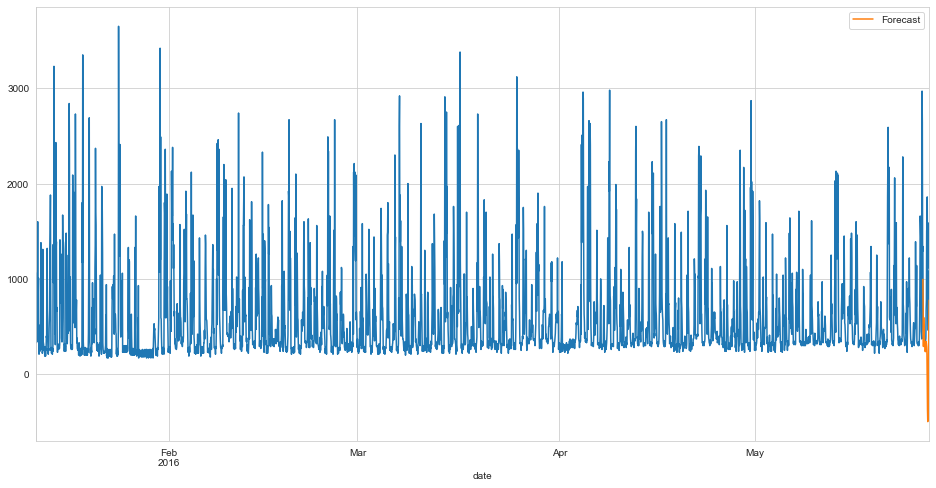

In [78]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(406699.0, 406770.0)

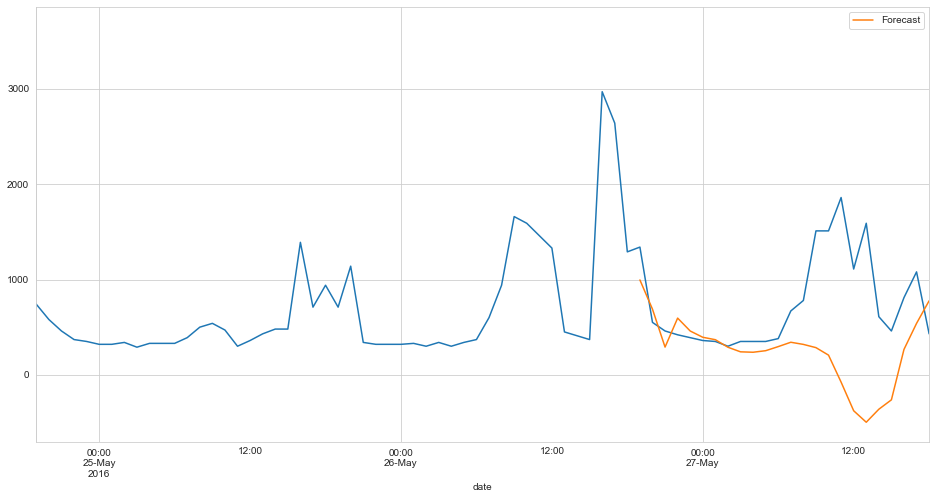

In [79]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2016-05-24 19:00:00', '2016-05-27 18:00:00')

<p style="text-align: center"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>